# Numerical Optimization

## Introduction

We consider convex problems with sufficient regularity, such that gradient information may be used. Algorithms that use these properties can be broadly classified as either **Line Search** methods or **Trust Region** methods. The exposition here follors Nocedal and Wright, which is an excellent introduction to the topic. I am not aiming for mathematical rigor, nor for completeness. Rather, I would like to revise some of the key concepts myself and give a nice first introduction, complete with the intuition and some working code.


### Preparation

Before we explore some approaches, we need a differentiable function complete with gradient information. As we want make ourselves familiar with ML-relevant tools out there, we will make use of the library PyTorch and its auto-differentiation capabilities. As usual, numpy and matplotlib will be useful as well:

**Disclaimer:** the code in this article could be greatly simplified by just using numpy instead of PyTorch. If you are mainly interested in numerical optimization, I suggest to do this, as this will clarify the core concepts.

In [362]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.autograd as autograd

Let us define a two-dimensional objective function, which we will be minimizing.

In [375]:
d = 2

# random quadratic form
class quadratic_form(torch.nn.Module):
  def __init__(self, D_in):
    super().__init__()
    self.c = torch.randn(1)
    self.b = torch.randn(D_in, 1)
    self.A = np.random.standard_exponential((D_in,D_in))
    #self.A = np.tril(self.A) + np.tril(self.A, -1).T
    self.A = torch.from_numpy(self.A).float()
    self.A = self.A.T @ self.A
  def forward(self, x):
    # x = torch.from_numpy(x).float()
    # x.requires_grad = True
    y = torch.sum(x * (self.A@x), 0) - 2.0 * self.b.T @ x + self.c
    return y

# We also need a pathological case
class rosenbrock_form(torch.nn.Module):
    def __init__(self):
      super().__init__()
    def forward(self, x):
      y = (1 - x[0])**2 + 100*(x[1]-x[0]**2)**2
    
objective_function = quadratic_form(d)
rosenbrock_function = rosenbrock_form()

As we are using PyTorch, we can make use of auto-differentiation to evaluate the gradient information with respect to the input $x$. A nice introduction to autograd in PyTorch can be found [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

In [376]:
# getting the gradient
x0 = torch.rand(2,1, requires_grad=True)
f0 = objective_function(x0) # forward pass
f0.backward() # after having computed one step, this will compute the gradient
print(x0.grad)

tensor([[2.0763],
        [1.6066]])


Bingo! We will also need a function to visualize our minimizer:

In [377]:
def plot_minimizier(f, bounds=[-10, 10, -10, 10], trace=np.empty(0)):
  x = np.linspace(bounds[0], bounds[1], 40, dtype=np.float32)
  y = np.linspace(bounds[2], bounds[3], 40, dtype=np.float32)
  X, Y = np.meshgrid(x, y)
  grid = np.vstack((X.flatten(),Y.flatten()))
  Z = f(torch.from_numpy(grid))
  Z = np.reshape(Z.detach().numpy(), (40,40))

  plt.gca().set_aspect("equal")
  plt.gcf().set_size_inches(7.5, 5.5)
  contourplot = plt.contourf(X, Y, Z, levels=np.linspace(-np.amax(Z),np.amax(Z),50))
  cbar = plt.colorbar(contourplot)

  # plot a sequence of points to visualize the optimizer
  trace = np.array(trace)
  if trace.size != 0:
    plt.plot(trace[:,0], trace[:,1],'w.', linestyle='dashed')
    plt.show()

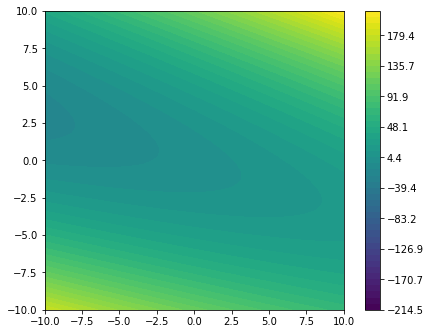

In [378]:
plot_minimizier(objective_function)

### Taylor's theorem

To illustrate both approaches, let us start with Taylor's theorem. Suppose that $f: \mathbb{R}^d \rightarrow \mathbb{R}$  is continuously differentiable and that $p \in \mathbb{R}^d$. Then, we have that

$$f(x+p) = f(x) + \nabla f(x + tp)^T p,$$

for some $t \in (0,1)$. Furthermore, if $f$ is twice continuously differentiable,

$$\nabla f(x+p) = \nabla f(x) + \int_0^1 \nabla^2 f(x+tp) p\;\mathrm{d}t,$$

which implies

$$f(x+p) = f(x) + \nabla f(x)^T p + \frac{1}{2}p^T \nabla^2 f(x+tp) p,$$

for some $t \in (0,1)$. Here, we have introduced the vector-valued gradient $\nabla f$ and the $d \times d$ Hessian matrix $\nabla^2 f$.

The latter implies $f(x+p) < f(x)$ for $p = - \alpha \nabla f(x)$, if some sufficiently small $\alpha$ is chosen. We can therefore update $x$ sequentially, such that $f(x)$ keeps decreasing, thus converging to a minimum.

## Line Search methods

This idea brings us to line-search methods. The core idea of Line Search method is to update the solution $x_k$ iteratively according to

$$x_{k+1} = x_k + \alpha_k p_k,$$

where $p_k$ is a descent direction (which is not necessarily the negative gradient) and $\alpha_k$ a certain step size. Ideally, this will result in a decreasing sequence

$$f(x_0) \geq f(x_1) \geq \dots \geq f(x_{k-1}) \geq f(x_k)$$

which converges to a certain minimum. These approaches are also called line-search methods, as we are looking for the minimum across the line defined by the search direction $p_k$. It is evident that convergence will depend on the specific choice of the descent direction $p_k$ and step size $\alpha_k$.

### Gradient descent

The natural choice for $p_k$ is to take the direction of steepest descent $-\nabla f(x_k)$. Taking the appropriate step size is a more difficult problem to solve. This leaves the choice regarding the step size open. A popular strategy is the so-called backtracking line-search. At each iteration, the following algorithm will give us a step-size $\alpha$:

In [379]:
def backtrack(f, x0, p0, alpha, tau=0.5, c=0.5):
  f0 = f(x0)
  m = torch.norm(p0) ** 2
  t = c * m
  while f0 - f(x0 + alpha * p0) <= alpha * t:
    alpha = tau*alpha
  return alpha


In other words, we start out with a certain step size $\alpha$ and decrease it iteratively as long as $f(x_0) - f(x_0 + \alpha p_0) \geq \alpha c ||p_0||^2$ is satisfied. $\tau \in (0,1)$ and $c \in (0,1)$ are some control parameters, which determine the behavior of the method. $\tau \in (0,1)$ is some shrinkage parameter, which controls the decay of $\alpha$, which is replaced by $\tau \alpha$ at each iteration. The parameter controls the maximal step size, as $\alpha$ will satisfy

$$f(x_0 + \alpha p_0) \leq f(x_0) + \alpha c ||p_0||^2,$$

which is also known as the Armijo–Goldstein condition (insert reference and say something about convergence).

Now that we have a method for choosing a step size, we can proceed by iteratively updating

In [380]:
def iterate(f, x0, alpha=1.0, tol=1e-6):

  # initialize the procedure
  x = x0
  x.requires_grad = True
  f0 = f(x)
  f0.backward()
  p = - x.grad

  # track the progress in trace
  trace = [x.detach().numpy()]

  # iterate 
  k = 0
  while k < 20 and alpha > tol:
    # for the following steps, we do not wish to track gradient information
    # to the end, we use torch.no_grad()
    with torch.no_grad():
      alpha = backtrack(f, x, p, alpha)
      x = x + alpha * p
    trace.append(x.detach().numpy())
    x.requires_grad = True
    f.zero_grad()
    f0 = f(x)
    f0.backward()
    p = - x.grad
    k += 1
  # compute the Wolfe condition
  return trace

x0 = torch.tensor([[10.],[10.]], requires_grad=True)
f0 = objective_function(x0)
trace = iterate(objective_function, x0)
  

We run the iteration 20 times or until the step size becomes too small. This gives us the following output, which is a list containing each of the iterates $x_k$:

In [381]:
trace

[array([[10.],
        [10.]], dtype=float32),
 array([[7.286171 ],
        [2.4017153]], dtype=float32),
 array([[ 6.0565863 ],
        [-0.31190586]], dtype=float32),
 array([[ 5.371312],
        [-1.235259]], dtype=float32),
 array([[ 4.8858376],
        [-1.5025219]], dtype=float32),
 array([[ 4.4738903],
        [-1.5293999]], dtype=float32),
 array([[ 4.0891876],
        [-1.46826  ]], dtype=float32),
 array([[ 3.7147648],
        [-1.374949 ]], dtype=float32),
 array([[ 3.3444042],
        [-1.2699355]], dtype=float32),
 array([[ 2.975826],
        [-1.160722]], dtype=float32),
 array([[ 2.6081946],
        [-1.0500582]], dtype=float32),
 array([[ 2.241203  ],
        [-0.93895185]], dtype=float32),
 array([[ 1.8747386 ],
        [-0.82777214]], dtype=float32),
 array([[ 1.5087595],
        [-0.7166543]], dtype=float32),
 array([[ 1.1432502 ],
        [-0.60564774]], dtype=float32),
 array([[ 0.7782046 ],
        [-0.49477053]], dtype=float32),
 array([[ 0.41362005],
        [-0

Let us use the plotting routine from before to visualize the minimization process.

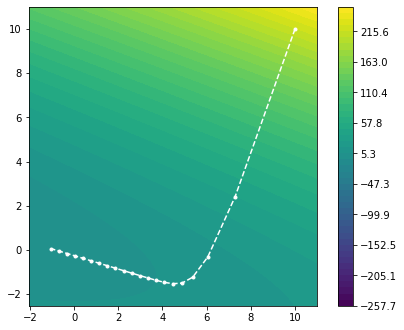

In [382]:
trace = np.array(trace)
bounds = [np.amin(trace[:,0]) - 1., np.amax(trace[:,0]) + 1., np.amin(trace[:,1]) - 1., np.amax(trace[:,1]) + 1.]
plot_minimizier(objective_function, bounds=bounds, trace=trace)

Nice! We can see that the updates are parallel to the gradient and move in the direction of steepest descent as we expected. Moreover, we observe that the step sizes $\alpha_k$ seem to be chosen reasonably, such that the method converges to the minimum. In fact, the Armillo-Goldstein condition with the chosen parameter is sufficient to guarantee convergence for a strictly convex function (insert ref.).

## Analogy to linear systems

Coming from numerical linear algebra, I couldn't resist to introduce some linear algebra. A central problem of numerical linear algebra is the solution of linear systems of the form $Ax = b.$

## References